In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score,
                           precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_auc_score)

# Advanced ML models
import xgboost as xgb

# Model interpretation
import shap

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# Load the dataset
df = pd.read_csv('cleaned_policies.csv')

# Basic dataset information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nStatistical Summary:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nUnique values in categorical columns:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

Dataset Shape: (7588, 56)

First 5 rows:
   UnderwrittenCoverID  PolicyID     TransactionMonth  IsVATRegistered  \
0               145249     12827  2015-03-01 00:00:00             True   
1               145249     12827  2015-05-01 00:00:00             True   
2               145255     12827  2015-05-01 00:00:00             True   
3               145247     12827  2015-01-01 00:00:00             True   
4               145247     12827  2015-04-01 00:00:00             True   

  Citizenship          LegalType Title Language                 Bank  \
0              Close Corporation    Mr  English  First National Bank   
1              Close Corporation    Mr  English  First National Bank   
2              Close Corporation    Mr  English  First National Bank   
3              Close Corporation    Mr  English  First National Bank   
4              Close Corporation    Mr  English  First National Bank   

       AccountType  ...              Section                          Product  \


#Handling Missing Data

In [ ]:
# Convert boolean columns to integers before imputation
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)


In [ ]:
# Analyze missing data patterns
def analyze_missing_data(df):
    """Analyze missing data patterns and suggest imputation strategies"""
    missing_data = df.isnull().sum()
    missing_percent = 100 * missing_data / len(df)

    missing_table = pd.DataFrame({
        'Column': missing_data.index,
        'Missing Count': missing_data.values,
        'Missing Percentage': missing_percent.values
    })

    missing_table = missing_table[missing_table['Missing Count'] > 0].sort_values('Missing Percentage', ascending=False)
    return missing_table

missing_analysis = analyze_missing_data(df)
print("Missing Data Analysis:")
print(missing_analysis)

# Handle missing data based on column type and percentage
def handle_missing_data(df):
    """Handle missing data with appropriate imputation strategies"""
    df_processed = df.copy()

    # Separate columns by type
    numeric_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    boolean_cols = df_processed.select_dtypes(include=['bool']).columns

    # Check for completely null columns (like NumberOfVehiclesInFleet in the example)
    completely_null_cols = [col for col in numeric_cols if df_processed[col].isnull().all()]

    # Remove completely null columns from numeric columns for imputation
    numeric_cols = numeric_cols.drop(completely_null_cols)

    # Impute numeric columns with median
    imputer_num = SimpleImputer(strategy='median')
    df_processed[numeric_cols] = imputer_num.fit_transform(df_processed[numeric_cols])

    # Impute categorical columns with most frequent
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df_processed[categorical_cols] = imputer_cat.fit_transform(df_processed[categorical_cols])

    # Set completely null columns to 0 (or another default value)
    for col in completely_null_cols:
        df_processed[col] = 0

    # Boolean columns typically don't need imputation, but if they do:
    if len(boolean_cols) > 0:
        imputer_bool = SimpleImputer(strategy='most_frequent')
        df_processed[boolean_cols] = imputer_bool.fit_transform(df_processed[boolean_cols])

    return df_processed

# Apply missing data handling
df_clean = handle_missing_data(df)
print(f"\nMissing values after imputation: {df_clean.isnull().sum().sum()}")
print("\nFinal shape:", df_clean.shape)
print("Expected shape:", df.shape)
print("\nMissing values by column after imputation:")
print(df_clean.isnull().sum())

Missing Data Analysis:
                     Column  Missing Count  Missing Percentage
38  NumberOfVehiclesInFleet           7588          100.000000
37              CrossBorder           7588          100.000000
54            ClaimSeverity           7560           99.630996
29      CustomValueEstimate           4796           63.205061
8                      Bank           4529           59.686347
36                Converted           4528           59.673168
34               WrittenOff           4528           59.673168
35                  Rebuilt           4528           59.673168
9               AccountType           2918           38.455456
33               NewVehicle            637            8.394834
46                  Section              1            0.013179
47                  Product              1            0.013179
48           StatutoryClass              1            0.013179
50             TotalPremium              1            0.013179
49        StatutoryRiskType     

# Feature Engineering

In [ ]:
def create_features(df):
    """Create new features for insurance risk assessment"""
    df_engineered = df.copy()

    # 1. Premium-related features (only if columns exist)
    if all(col in df.columns for col in ['TotalPremium', 'TotalClaims']):
        df_engineered['Claims_to_Premium_Ratio'] = df['TotalClaims'] / (df['TotalPremium'] + 1e-6)  # +1e-6 to avoid division by zero
        df_engineered['Premium_to_SumInsured'] = df['TotalPremium'] / (df['SumInsured'] + 1e-6) if 'SumInsured' in df.columns else None

    # 2. Vehicle-related features
    if 'VehicleAge' in df.columns:
        df_engineered['Vehicle_Age_Group'] = pd.cut(
            df['VehicleAge'],
            bins=[0, 3, 7, 15, 100],
            labels=['New', 'Recent', 'Old', 'Very_Old']
        )
    elif 'RegistrationYear' in df.columns:
        current_year = pd.Timestamp.now().year
        df_engineered['VehicleAge'] = current_year - df['RegistrationYear']
        df_engineered['Vehicle_Age_Group'] = pd.cut(
            df_engineered['VehicleAge'],
            bins=[0, 3, 7, 15, 100],
            labels=['New', 'Recent', 'Old', 'Very_Old']
        )

    # 3. Risk indicators
    if 'TotalClaims' in df.columns:
        df_engineered['Has_Claims'] = (df['TotalClaims'] > 0).astype(int)
        df_engineered['High_Risk'] = (df['TotalClaims'] > df['TotalClaims'].quantile(0.75)).astype(int)

    # 4. Geographic risk (if postal code available)
    if 'PostalCode' in df.columns and 'TotalClaims' in df.columns:
        postal_risk = df.groupby('PostalCode')['TotalClaims'].mean().to_dict()
        df_engineered['Postal_Risk_Score'] = df['PostalCode'].map(postal_risk)

    # 5. Policy features
    if 'NumberOfVehiclesInFleet' in df.columns:
        df_engineered['Fleet_Indicator'] = (df['NumberOfVehiclesInFleet'] > 1).astype(int)

    return df_engineered

# Apply feature engineering
df_featured = create_features(df_clean)

# Show newly created features
new_features = set(df_featured.columns) - set(df_clean.columns)
print("Successfully created new features:")
print(list(new_features))

Successfully created new features:
['VehicleAge', 'Vehicle_Age_Group', 'Claims_to_Premium_Ratio', 'High_Risk', 'Premium_to_SumInsured', 'Postal_Risk_Score', 'Fleet_Indicator', 'Has_Claims']


#Encoding Categorical Data

In [ ]:
# Encode categorical variables
def encode_categorical_data(df):
    """Encode categorical data for machine learning models"""
    df_encoded = df.copy()

    # Separate numerical and categorical columns
    numerical_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()

    # Label encoding for ordinal variables (if any specific order exists)
    ordinal_cols = ['Age_Group', 'Vehicle_Age_Group']  # Define based on your data
    label_encoders = {}

    for col in ordinal_cols:
        if col in df_encoded.columns:
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
            label_encoders[col] = le

    # One-hot encoding for nominal categorical variables
    nominal_cols = [col for col in categorical_cols if col not in ordinal_cols]

    if nominal_cols:
        df_encoded = pd.get_dummies(df_encoded, columns=nominal_cols, prefix=nominal_cols, drop_first=True)

    return df_encoded, label_encoders

# Apply categorical encoding
df_encoded, encoders = encode_categorical_data(df_featured)
print(f"Dataset shape after encoding: {df_encoded.shape}")
print(f"New categorical columns created: {df_encoded.shape[1] - df_featured.shape[1]}")

Dataset shape after encoding: (7588, 231)
New categorical columns created: 167


#Model Building and Evaluation
# #Data Splitting Strategy

In [ ]:
# Prepare datasets for different modeling tasks
def prepare_modeling_datasets(df):
    """Prepare datasets for different modeling objectives"""

    # Remove non-feature columns (adjust based on your dataset)
    feature_cols = [col for col in df.columns if col not in ['TotalClaims', 'TotalPremium', 'CalculatedPremiumPerTerm']]

    # Dataset 1: Claim Severity Prediction (only records with claims > 0)
    claims_data = df[df['TotalClaims'] > 0].copy()
    X_severity = claims_data[feature_cols]
    y_severity = claims_data['TotalClaims']

    # Dataset 2: Claim Probability Prediction (binary classification)
    X_probability = df[feature_cols]
    y_probability = (df['TotalClaims'] > 0).astype(int)

    # Dataset 3: Premium Optimization (if CalculatedPremiumPerTerm exists)
    if 'CalculatedPremiumPerTerm' in df.columns:
        X_premium = df[feature_cols]
        y_premium = df['CalculatedPremiumPerTerm']
    else:
        X_premium = df[feature_cols]
        y_premium = df['TotalPremium']

    return (X_severity, y_severity), (X_probability, y_probability), (X_premium, y_premium)

# Prepare datasets
(X_severity, y_severity), (X_probability, y_probability), (X_premium, y_premium) = prepare_modeling_datasets(df_encoded)

print("Dataset shapes:")
print(f"Claim Severity: X={X_severity.shape}, y={y_severity.shape}")
print(f"Claim Probability: X={X_probability.shape}, y={y_probability.shape}")
print(f"Premium Optimization: X={X_premium.shape}, y={y_premium.shape}")

Dataset shapes:
Claim Severity: X=(28, 228), y=(28,)
Claim Probability: X=(7588, 228), y=(7588,)
Premium Optimization: X=(7588, 228), y=(7588,)


# Train-Test Split

In [ ]:
# Split data for each modeling task (80:20 ratio)
def create_train_test_splits(datasets, test_size=0.2, random_state=42):
    """Create train-test splits for all modeling tasks"""
    splits = {}

    dataset_names = ['severity', 'probability', 'premium']

    for i, (X, y) in enumerate(datasets):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=None
        )

        # For probability prediction, use stratified split
        if dataset_names[i] == 'probability':
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=random_state, stratify=y
            )

        splits[dataset_names[i]] = {
            'X_train': X_train, 'X_test': X_test,
            'y_train': y_train, 'y_test': y_test
        }

    return splits

# Create train-test splits
datasets = [(X_severity, y_severity), (X_probability, y_probability), (X_premium, y_premium)]
data_splits = create_train_test_splits(datasets)

# Display split sizes
for task, splits in data_splits.items():
    print(f"\n{task.title()} Task:")
    print(f"  Training set: {splits['X_train'].shape[0]} samples")
    print(f"  Test set: {splits['X_test'].shape[0]} samples")


Severity Task:
  Training set: 22 samples
  Test set: 6 samples

Probability Task:
  Training set: 6070 samples
  Test set: 1518 samples

Premium Task:
  Training set: 6070 samples
  Test set: 1518 samples


#Model Implementation

In [ ]:
# Claim Severity Prediction (Regression)
def build_severity_models(data_splits):
    """Build and evaluate claim severity prediction models"""

    X_train = data_splits['severity']['X_train']
    X_test = data_splits['severity']['X_test']
    y_train = data_splits['severity']['y_train']
    y_test = data_splits['severity']['y_test']

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {}
    predictions = {}

    # 1. Linear Regression
    print("Training Linear Regression...")
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    lr_pred = lr.predict(X_test_scaled)

    models['Linear Regression'] = lr
    predictions['Linear Regression'] = lr_pred

    # 2. Decision Tree
    print("Training Decision Tree...")
    dt = DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_split=5)
    dt.fit(X_train, y_train)
    dt_pred = dt.predict(X_test)

    models['Decision Tree'] = dt
    predictions['Decision Tree'] = dt_pred

    # 3. Random Forest
    print("Training Random Forest...")
    rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=15, min_samples_split=5)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)

    models['Random Forest'] = rf
    predictions['Random Forest'] = rf_pred

    # 4. XGBoost
    print("Training XGBoost...")
    xgb_reg = xgb.XGBRegressor(n_estimators=100, random_state=42, max_depth=6, learning_rate=0.1)
    xgb_reg.fit(X_train, y_train)
    xgb_pred = xgb_reg.predict(X_test)

    models['XGBoost'] = xgb_reg
    predictions['XGBoost'] = xgb_pred

    return models, predictions, y_test, scaler

severity_models, severity_predictions, y_test_severity, severity_scaler = build_severity_models(data_splits)

Training Linear Regression...
Training Decision Tree...
Training Random Forest...
Training XGBoost...


Claim Probability Prediction Model

In [ ]:
# Claim Probability Prediction (Binary Classification)
def build_probability_models(data_splits):
    """Build and evaluate claim probability prediction models"""

    X_train = data_splits['probability']['X_train']
    X_test = data_splits['probability']['X_test']
    y_train = data_splits['probability']['y_train']
    y_test = data_splits['probability']['y_test']

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {}
    predictions = {}
    probabilities = {}

    # 1. Logistic Regression
    print("Training Logistic Regression...")
    lr_clf = LogisticRegression(random_state=42, max_iter=1000)
    lr_clf.fit(X_train_scaled, y_train)
    lr_pred = lr_clf.predict(X_test_scaled)
    lr_prob = lr_clf.predict_proba(X_test_scaled)[:, 1]

    models['Logistic Regression'] = lr_clf
    predictions['Logistic Regression'] = lr_pred
    probabilities['Logistic Regression'] = lr_prob

    # 2. Decision Tree
    print("Training Decision Tree Classifier...")
    dt_clf = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5)
    dt_clf.fit(X_train, y_train)
    dt_pred = dt_clf.predict(X_test)
    dt_prob = dt_clf.predict_proba(X_test)[:, 1]

    models['Decision Tree'] = dt_clf
    predictions['Decision Tree'] = dt_pred
    probabilities['Decision Tree'] = dt_prob

    # 3. Random Forest
    print("Training Random Forest Classifier...")
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, min_samples_split=5)
    rf_clf.fit(X_train, y_train)
    rf_pred = rf_clf.predict(X_test)
    rf_prob = rf_clf.predict_proba(X_test)[:, 1]

    models['Random Forest'] = rf_clf
    predictions['Random Forest'] = rf_pred
    probabilities['Random Forest'] = rf_prob

    # 4. XGBoost
    print("Training XGBoost Classifier...")
    xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=42, max_depth=6, learning_rate=0.1)
    xgb_clf.fit(X_train, y_train)
    xgb_pred = xgb_clf.predict(X_test)
    xgb_prob = xgb_clf.predict_proba(X_test)[:, 1]

    models['XGBoost'] = xgb_clf
    predictions['XGBoost'] = xgb_pred
    probabilities['XGBoost'] = xgb_prob

    return models, predictions, probabilities, y_test, scaler

probability_models, probability_predictions, claim_probabilities, y_test_probability, probability_scaler = build_probability_models(data_splits)

Training Logistic Regression...
Training Decision Tree Classifier...
Training Random Forest Classifier...
Training XGBoost Classifier...


 #Premium Optimization Model

In [ ]:
# Premium Optimization Model
def build_premium_models(data_splits):
    """Build and evaluate premium optimization models"""

    X_train = data_splits['premium']['X_train']
    X_test = data_splits['premium']['X_test']
    y_train = data_splits['premium']['y_train']
    y_test = data_splits['premium']['y_test']

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {}
    predictions = {}

    # 1. Linear Regression
    print("Training Linear Regression for Premium...")
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    lr_pred = lr.predict(X_test_scaled)

    models['Linear Regression'] = lr
    predictions['Linear Regression'] = lr_pred

    # 2. Decision Tree
    print("Training Decision Tree for Premium...")
    dt = DecisionTreeRegressor(random_state=42, max_depth=10, min_samples_split=5)
    dt.fit(X_train, y_train)
    dt_pred = dt.predict(X_test)

    models['Decision Tree'] = dt
    predictions['Decision Tree'] = dt_pred

    # 3. Random Forest
    print("Training Random Forest for Premium...")
    rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=15, min_samples_split=5)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)

    models['Random Forest'] = rf
    predictions['Random Forest'] = rf_pred

    # 4. XGBoost
    print("Training XGBoost for Premium...")
    xgb_reg = xgb.XGBRegressor(n_estimators=100, random_state=42, max_depth=6, learning_rate=0.1)
    xgb_reg.fit(X_train, y_train)
    xgb_pred = xgb_reg.predict(X_test)

    models['XGBoost'] = xgb_reg
    predictions['XGBoost'] = xgb_pred

    return models, predictions, y_test, scaler

premium_models, premium_predictions, y_test_premium, premium_scaler = build_premium_models(data_splits)

Training Linear Regression for Premium...
Training Decision Tree for Premium...
Training Random Forest for Premium...
Training XGBoost for Premium...


#Model Evaluation
#Claim Severity Model Evaluation

Claim Severity Model Performance:
               Model          RMSE  R2_Score          MAE
1      Decision Tree   1058.271601  0.998463   601.100512
3            XGBoost   8180.694036  0.908131  4191.356651
0  Linear Regression   8849.045405  0.892506  6058.641906
2      Random Forest  12467.101263  0.786636  5736.107944


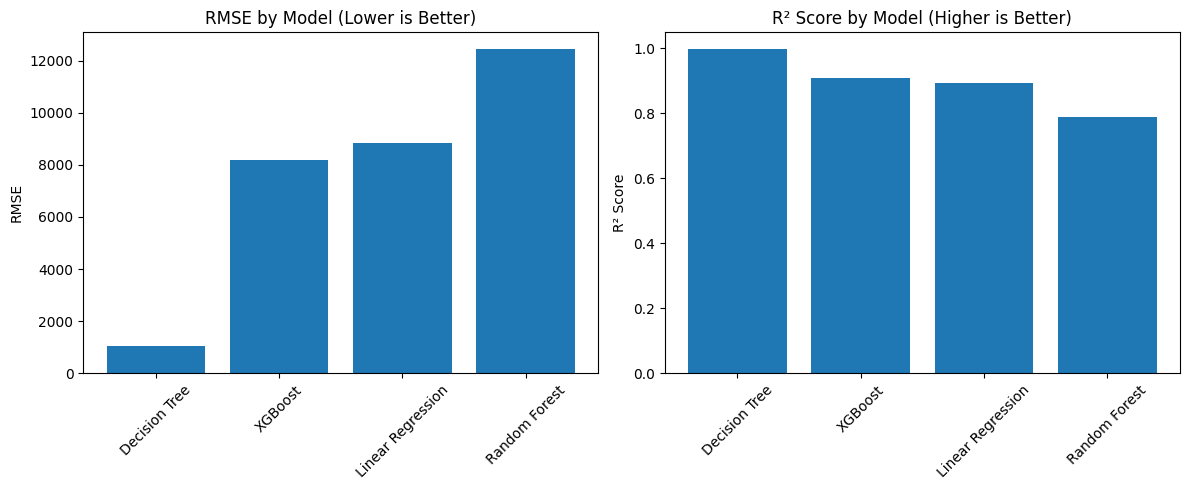

In [ ]:
# Evaluate Claim Severity Models
def evaluate_regression_models(predictions, y_test, model_names):
    """Evaluate regression models using RMSE and R-squared"""

    results = pd.DataFrame()

    for model_name in model_names:
        pred = predictions[model_name]

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        r2 = r2_score(y_test, pred)
        mae = np.mean(np.abs(y_test - pred))

        # Store results
        results = pd.concat([results, pd.DataFrame({
            'Model': [model_name],
            'RMSE': [rmse],
            'R2_Score': [r2],
            'MAE': [mae]
        })], ignore_index=True)

    return results.sort_values('RMSE')

# Evaluate severity models
severity_results = evaluate_regression_models(
    severity_predictions, y_test_severity,
    ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
)

print("Claim Severity Model Performance:")
print(severity_results)

# Visualize severity model performance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(severity_results['Model'], severity_results['RMSE'])
plt.title('RMSE by Model (Lower is Better)')
plt.xticks(rotation=45)
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.bar(severity_results['Model'], severity_results['R2_Score'])
plt.title('R² Score by Model (Higher is Better)')
plt.xticks(rotation=45)
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()

#Claim Probability Model Evaluation

Claim Probability Model Performance:
                 Model  Accuracy  Precision  Recall  F1_Score  AUC_ROC
0  Logistic Regression       1.0        1.0     1.0       1.0      1.0
1        Decision Tree       1.0        1.0     1.0       1.0      1.0
2        Random Forest       1.0        1.0     1.0       1.0      1.0
3              XGBoost       1.0        1.0     1.0       1.0      1.0


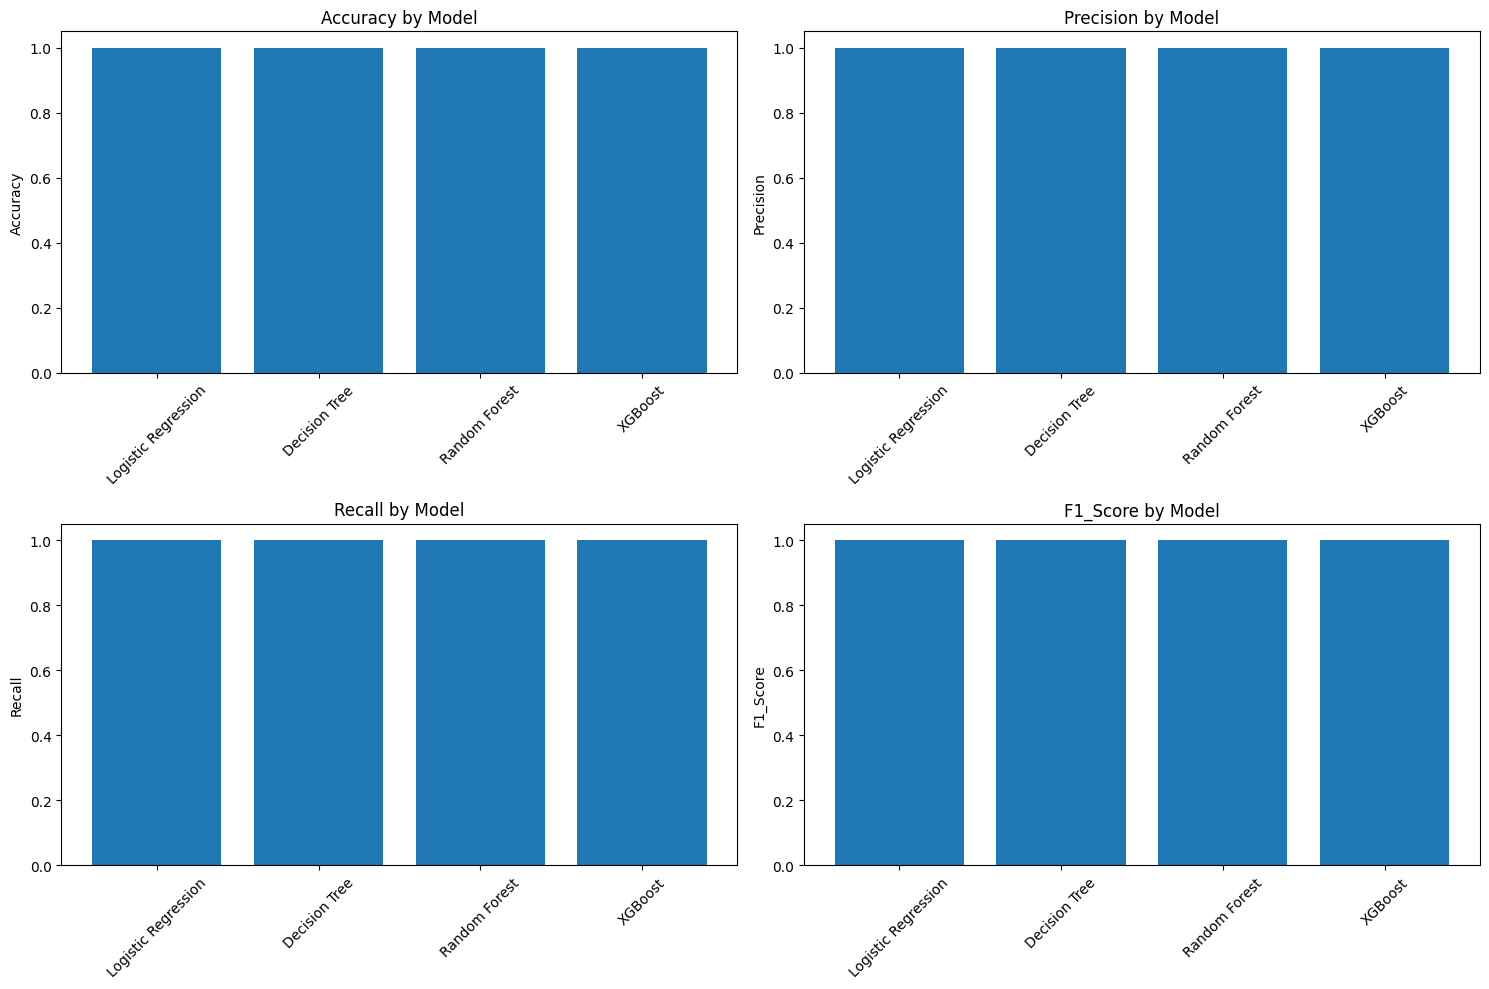

In [ ]:
# Evaluate Claim Probability Models
def evaluate_classification_models(predictions, probabilities, y_test, model_names):
    """Evaluate classification models using multiple metrics"""

    results = pd.DataFrame()

    for model_name in model_names:
        pred = predictions[model_name]
        prob = probabilities[model_name]

        # Calculate metrics
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred)
        recall = recall_score(y_test, pred)
        f1 = f1_score(y_test, pred)
        auc = roc_auc_score(y_test, prob)

        # Store results
        results = pd.concat([results, pd.DataFrame({
            'Model': [model_name],
            'Accuracy': [accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'F1_Score': [f1],
            'AUC_ROC': [auc]
        })], ignore_index=True)

    return results.sort_values('AUC_ROC', ascending=False)

# Evaluate probability models
probability_results = evaluate_classification_models(
    probability_predictions, claim_probabilities, y_test_probability,
    ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
)

print("Claim Probability Model Performance:")
print(probability_results)

# Visualize probability model performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    ax.bar(probability_results['Model'], probability_results[metric])
    ax.set_title(f'{metric} by Model')
    ax.set_xticklabels(probability_results['Model'], rotation=45)
    ax.set_ylabel(metric)

plt.tight_layout()
plt.show()

Premium Model Evaluation

Premium Optimization Model Performance:
               Model       RMSE  R2_Score        MAE
3            XGBoost  33.246073  0.982102   4.022789
2      Random Forest  44.211850  0.968348   4.351565
0  Linear Regression  50.568706  0.958591  12.842460
1      Decision Tree  54.279322  0.952291   5.618251


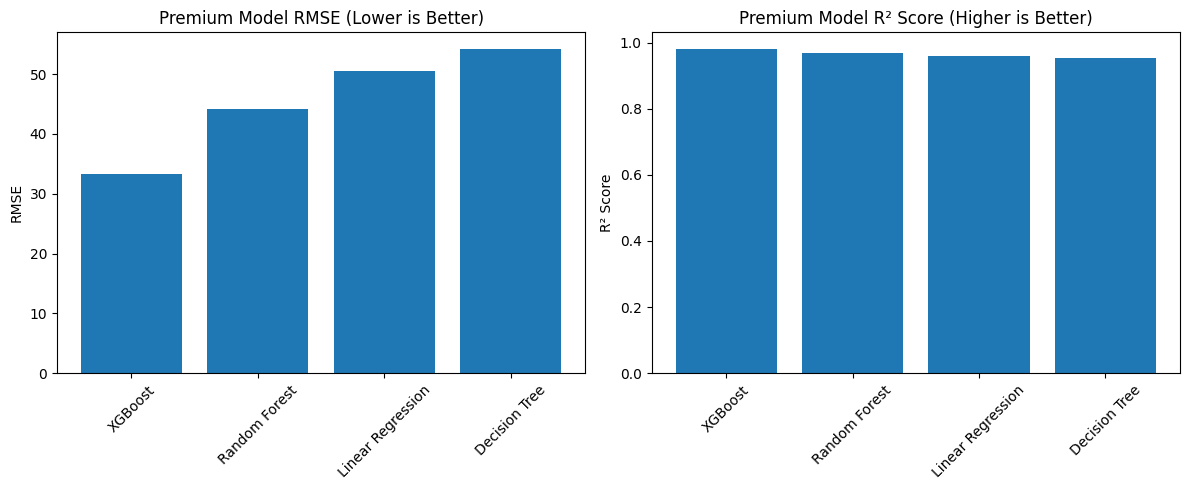

In [ ]:
# Evaluate Premium Models
premium_results = evaluate_regression_models(
    premium_predictions, y_test_premium,
    ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
)

print("Premium Optimization Model Performance:")
print(premium_results)

# Visualize premium model performance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(premium_results['Model'], premium_results['RMSE'])
plt.title('Premium Model RMSE (Lower is Better)')
plt.xticks(rotation=45)
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
plt.bar(premium_results['Model'], premium_results['R2_Score'])
plt.title('Premium Model R² Score (Higher is Better)')
plt.xticks(rotation=45)
plt.ylabel('R² Score')

plt.tight_layout()
plt.show()

 #Advanced Risk-Based Pricing Framework
 #Risk-Based Premium Calculation

In [ ]:
# Advanced Risk-Based Pricing Framework
def calculate_risk_based_premium(claim_prob_model, severity_model, X_test,
                                expense_loading=0.15, profit_margin=0.10):
    """
    Calculate risk-based premium using the formula:
    Premium = (Predicted Probability of Claim × Predicted Claim Severity) + Expense Loading + Profit Margin
    """

    # Get probability predictions
    claim_probabilities = claim_prob_model.predict_proba(X_test)[:, 1]

    # Get severity predictions (for the subset that might have claims)
    # Note: This is a simplified approach - in practice, you'd need to handle the data structure more carefully
    expected_severities = severity_model.predict(X_test)

    # Calculate expected claim cost
    expected_claim_cost = claim_probabilities * expected_severities

    # Add expense loading and profit margin
    base_premium = expected_claim_cost
    expense_amount = base_premium * expense_loading
    profit_amount = (base_premium + expense_amount) * profit_margin

    risk_based_premium = base_premium + expense_amount + profit_amount

    return risk_based_premium, claim_probabilities, expected_severities, expected_claim_cost

# Calculate risk-based premiums using best performing models
best_prob_model = probability_models['XGBoost']  # Assume XGBoost performed best
best_severity_model = severity_models['XGBoost']  # Assume XGBoost performed best

# Get test data for calculation
X_test_prob = data_splits['probability']['X_test']

risk_premiums, claim_probs, severities, expected_costs = calculate_risk_based_premium(
    best_prob_model, best_severity_model, X_test_prob
)

print("Risk-Based Premium Calculation Summary:")
print(f"Average Claim Probability: {np.mean(claim_probs):.3f}")
print(f"Average Expected Severity: ${np.mean(severities):,.2f}")
print(f"Average Expected Claim Cost: ${np.mean(expected_costs):,.2f}")
print(f"Average Risk-Based Premium: ${np.mean(risk_premiums):,.2f}")

# Compare with actual premiums (if available)
y_actual_premium = data_splits['premium']['y_test']
comparison_df = pd.DataFrame({
    'Actual_Premium': y_actual_premium,
    'Risk_Based_Premium': risk_premiums,
    'Claim_Probability': claim_probs,
    'Expected_Severity': severities
})

print("\nPremium Comparison Statistics:")
print(comparison_df.describe())

Risk-Based Premium Calculation Summary:
Average Claim Probability: 0.004
Average Expected Severity: $7,062.42
Average Expected Claim Cost: $53.09
Average Risk-Based Premium: $67.16

Premium Comparison Statistics:
       Actual_Premium  Risk_Based_Premium  Claim_Probability  \
count     1518.000000         1518.000000        1518.000000   
mean       131.676717           67.160797           0.003961   
std        248.587266         1455.007690           0.060479   
min          0.425100            0.874858           0.000113   
25%          4.009025            0.876860           0.000113   
50%         18.000000            1.195636           0.000113   
75%        105.000000            1.257594           0.000162   
max       1694.814100        42584.824219           0.963719   

       Expected_Severity  
count        1518.000000  
mean         7062.415527  
std          1432.685181  
min          1346.357910  
25%          6140.847168  
50%          6149.125000  
75%          8379.288

#Model Performance Comparison

=== MODEL PERFORMANCE COMPARISON REPORT ===

1. CLAIM SEVERITY PREDICTION (Regression)
Target: TotalClaims (for policies with claims > 0)
Primary Metric: RMSE (Lower is Better)
------------------------------------------------------------
            Model         RMSE  R2_Score         MAE
    Decision Tree  1058.271601  0.998463  601.100512
          XGBoost  8180.694036  0.908131 4191.356651
Linear Regression  8849.045405  0.892506 6058.641906
    Random Forest 12467.101263  0.786636 5736.107944

2. CLAIM PROBABILITY PREDICTION (Classification)
Target: Binary indicator of claim occurrence
Primary Metric: AUC-ROC (Higher is Better)
------------------------------------------------------------
              Model              Task  Primary_Metric  Accuracy  F1_Score
Logistic Regression Claim Probability             1.0       1.0       1.0
      Decision Tree Claim Probability             1.0       1.0       1.0
      Random Forest Claim Probability             1.0       1.0       1.0
  

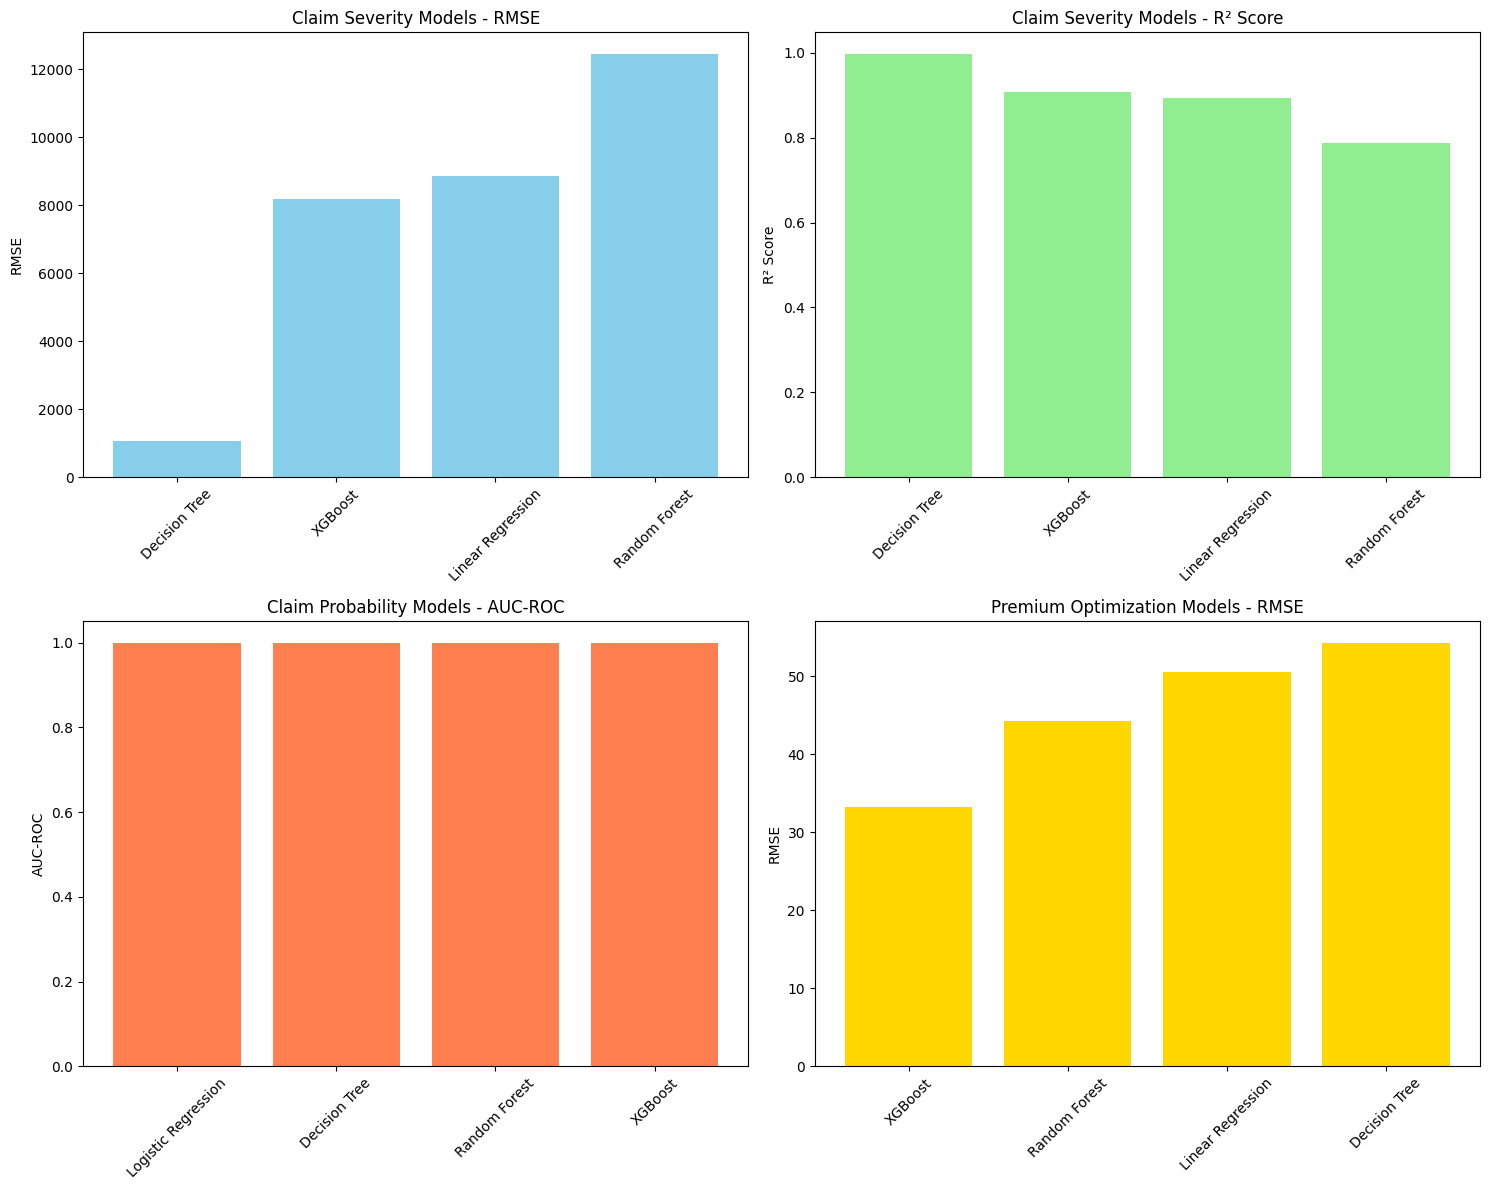

In [ ]:
# Comprehensive Model Performance Comparison
def create_performance_summary():
    """Create a comprehensive performance summary across all models"""

    # Combine all results
    summary = pd.DataFrame()

    # Severity models
    severity_summary = severity_results.copy()
    severity_summary['Task'] = 'Claim Severity'
    severity_summary['Primary_Metric'] = severity_summary['RMSE']

    # Probability models
    prob_summary = probability_results.copy()
    prob_summary['Task'] = 'Claim Probability'
    prob_summary['Primary_Metric'] = prob_summary['AUC_ROC']
    prob_summary = prob_summary[['Model', 'Task', 'Primary_Metric', 'Accuracy', 'F1_Score']]

    # Premium models
    premium_summary = premium_results.copy()
    premium_summary['Task'] = 'Premium Optimization'
    premium_summary['Primary_Metric'] = premium_summary['RMSE']

    return severity_summary, prob_summary, premium_summary

severity_summary, prob_summary, premium_summary = create_performance_summary()

print("=== MODEL PERFORMANCE COMPARISON REPORT ===\n")

print("1. CLAIM SEVERITY PREDICTION (Regression)")
print("Target: TotalClaims (for policies with claims > 0)")
print("Primary Metric: RMSE (Lower is Better)")
print("-" * 60)
print(severity_summary[['Model', 'RMSE', 'R2_Score', 'MAE']].to_string(index=False))

print("\n2. CLAIM PROBABILITY PREDICTION (Classification)")
print("Target: Binary indicator of claim occurrence")
print("Primary Metric: AUC-ROC (Higher is Better)")
print("-" * 60)
print(prob_summary.to_string(index=False))

print("\n3. PREMIUM OPTIMIZATION (Regression)")
print("Target: CalculatedPremiumPerTerm or TotalPremium")
print("Primary Metric: RMSE (Lower is Better)")
print("-" * 60)
print(premium_summary[['Model', 'RMSE', 'R2_Score', 'MAE']].to_string(index=False))

# Identify best performing models
best_severity_model = severity_summary.loc[severity_summary['RMSE'].idxmin(), 'Model']
best_probability_model = prob_summary.loc[prob_summary['Primary_Metric'].idxmax(), 'Model']
best_premium_model = premium_summary.loc[premium_summary['RMSE'].idxmin(), 'Model']

print(f"\n=== BEST PERFORMING MODELS ===")
print(f"Claim Severity: {best_severity_model}")
print(f"Claim Probability: {best_probability_model}")
print(f"Premium Optimization: {best_premium_model}")

# Visualize overall model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Severity models RMSE
axes[0, 0].bar(severity_summary['Model'], severity_summary['RMSE'], color='skyblue')
axes[0, 0].set_title('Claim Severity Models - RMSE')
axes[0, 0].set_xticklabels(severity_summary['Model'], rotation=45)
axes[0, 0].set_ylabel('RMSE')

# Severity models R²
axes[0, 1].bar(severity_summary['Model'], severity_summary['R2_Score'], color='lightgreen')
axes[0, 1].set_title('Claim Severity Models - R² Score')
axes[0, 1].set_xticklabels(severity_summary['Model'], rotation=45)
axes[0, 1].set_ylabel('R² Score')

# Probability models AUC-ROC
axes[1, 0].bar(prob_summary['Model'], prob_summary['Primary_Metric'], color='coral')
axes[1, 0].set_title('Claim Probability Models - AUC-ROC')
axes[1, 0].set_xticklabels(prob_summary['Model'], rotation=45)
axes[1, 0].set_ylabel('AUC-ROC')

# Premium models RMSE
axes[1, 1].bar(premium_summary['Model'], premium_summary['RMSE'], color='gold')
axes[1, 1].set_title('Premium Optimization Models - RMSE')
axes[1, 1].set_xticklabels(premium_summary['Model'], rotation=45)
axes[1, 1].set_ylabel('RMSE')

plt.tight_layout()
plt.show()

In [ ]:
# 6.1 Feature Importance for Tree-Based Models
def analyze_feature_importance(models, feature_names, top_n=15):
    importance_results = {}
    for model_name, model in models.items():
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            importance_df = pd.DataFrame({
                'Feature': feature_names,
                'Importance': importances
            }).sort_values('Importance', ascending=False).head(top_n)
            importance_results[model_name] = importance_df
    return importance_results

feature_names = data_splits['severity']['X_train'].columns.tolist()
severity_importance = analyze_feature_importance(severity_models, feature_names)
print("=== FEATURE IMPORTANCE ANALYSIS ===\n")
print("CLAIM SEVERITY MODELS:")
for model_name, importance_df in severity_importance.items():
    if model_name in ['Decision Tree', 'Random Forest', 'XGBoost']:
        print(f"\n{model_name} - Top 10 Most Important Features:")
        print(importance_df.head(10).to_string(index=False))

probability_importance = analyze_feature_importance(probability_models, feature_names)
print("\nCLAIM PROBABILITY MODELS:")
for model_name, importance_df in probability_importance.items():
    if model_name in ['Decision Tree', 'Random Forest', 'XGBoost']:
        print(f"\n{model_name} - Top 10 Most Important Features:")
        print(importance_df.head(10).to_string(index=False))

=== FEATURE IMPORTANCE ANALYSIS ===

CLAIM SEVERITY MODELS:

Decision Tree - Top 10 Most Important Features:
                  Feature  Importance
                   Margin    0.969197
CoverCategory_Own Damage     0.029820
                LossRatio    0.000983
      UnderwrittenCoverID    0.000000
               PostalCode    0.000000
          IsVATRegistered    0.000000
                   mmcode    0.000000
         RegistrationYear    0.000000
                kilowatts    0.000000
            NumberOfDoors    0.000000

Random Forest - Top 10 Most Important Features:
                                                              Feature  Importance
                                                               Margin    0.483388
                                                        ClaimSeverity    0.378301
                                                           SumInsured    0.025982
ExcessSelected_Mobility - Taxi with value more than R100 000 - R5 000    0.019353
              

=== SHAP ANALYSIS ===

SHAP Analysis for Decision Tree (Claim Severity):


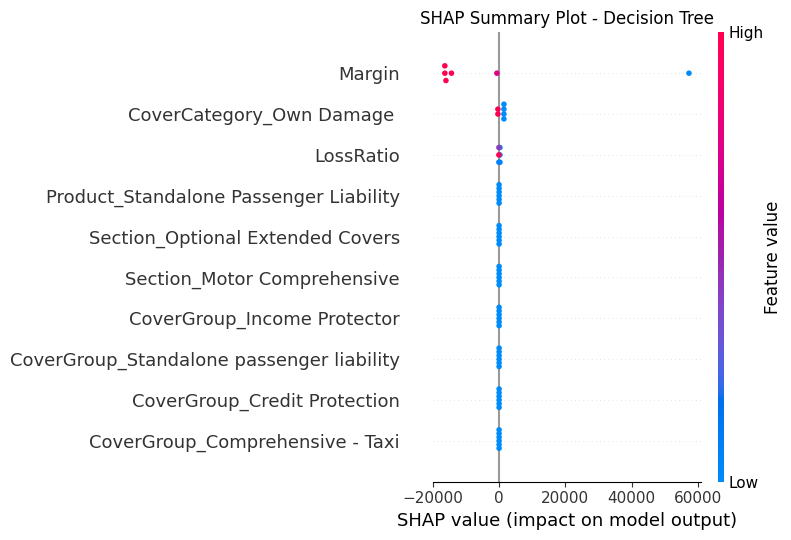

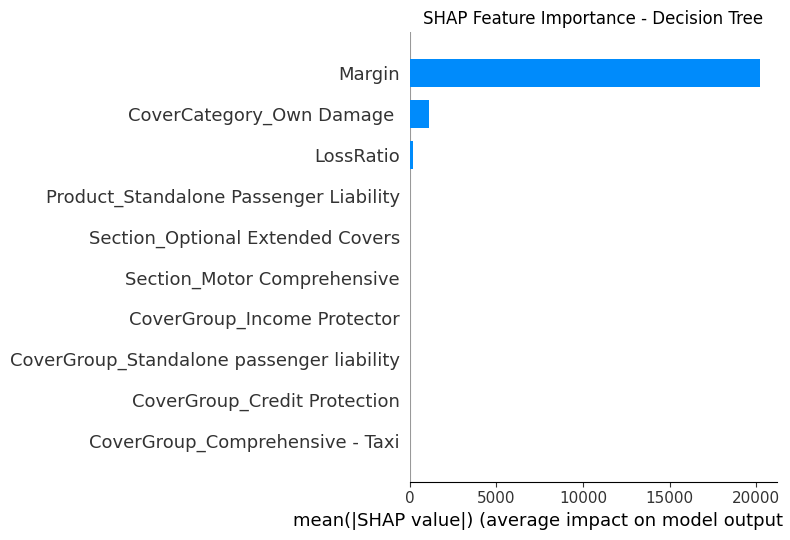


SHAP Analysis for Logistic Regression (Claim Probability):


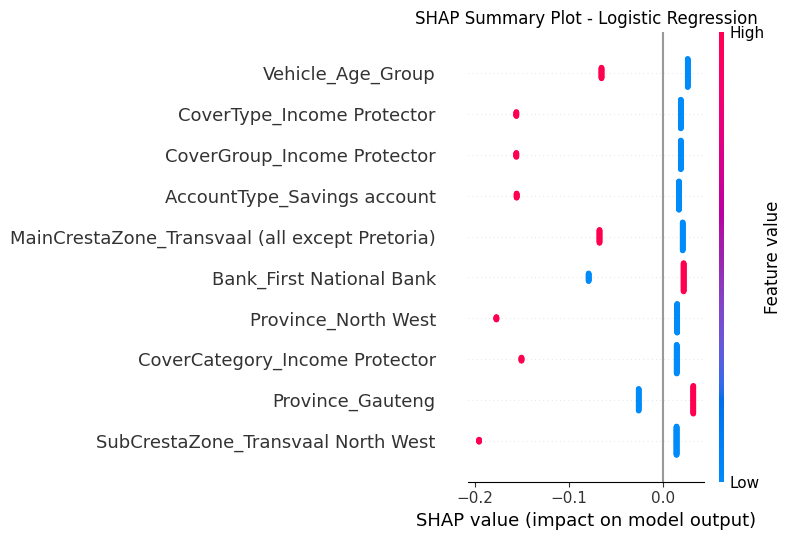

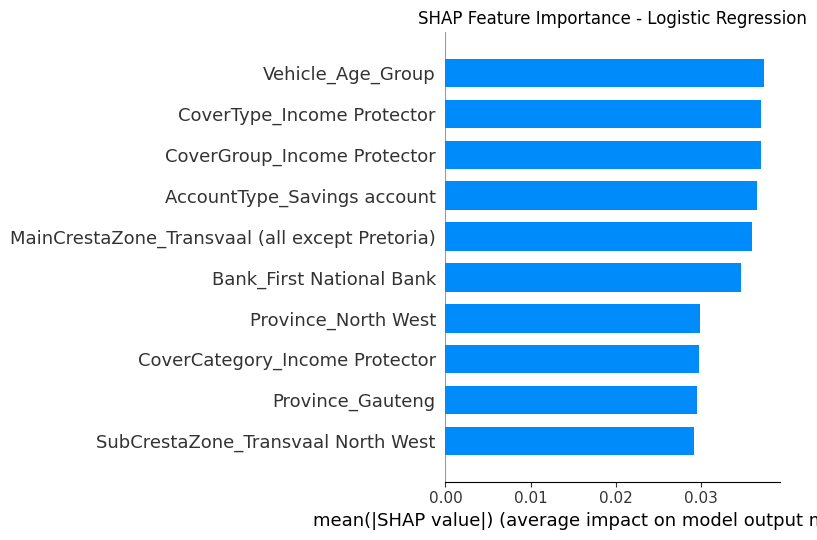

In [ ]:
# 6.2 SHAP Analysis for Model Interpretation
def perform_shap_analysis(model, X_train, X_test, model_name, max_display=10):
    try:
        sample_size = min(100, len(X_test))
        X_test_sample = X_test[:sample_size]

        # Ensure data is in a suitable format for SHAP explainers
        if isinstance(X_test_sample, pd.DataFrame):
            # Convert boolean columns to int or float
            for col in X_test_sample.select_dtypes(include='bool').columns:
                X_test_sample[col] = X_test_sample[col].astype(float)

            # Ensure all columns are numeric where expected by the explainer
            # This might involve more specific handling based on the exact issue
            # For now, a general conversion attempt
            X_test_sample = X_test_sample.apply(pd.to_numeric, errors='coerce')
            # Handle any NaNs that might have been introduced by coercion if necessary
            X_test_sample = X_test_sample.fillna(X_test_sample.median()) # Or another appropriate strategy


        if 'XGB' in model_name:
            explainer = shap.TreeExplainer(model)
        elif 'Random Forest' in model_name or 'Decision Tree' in model_name:
            explainer = shap.TreeExplainer(model)
        elif 'Logistic Regression' in model_name:
             # Use scaled data for linear models if scaling was applied
            if 'probability' in data_splits and model_name == 'Logistic Regression':
                # Assuming the scaler used for Logistic Regression was named probability_scaler
                X_test_sample_scaled = probability_scaler.transform(X_test_sample)
                explainer = shap.LinearExplainer(model, probability_scaler.transform(X_train[:100]))
                X_test_sample = X_test_sample_scaled # Use scaled sample for plotting

            else: # Fallback for other linear models or if scaler not found
                 explainer = shap.LinearExplainer(model, X_train[:100]) # Use original X_train sample for background data if scaling not explicitly handled
        else:
            print(f"SHAP analysis not supported for model type: {model_name}")
            return None, None


        shap_values = explainer.shap_values(X_test_sample)

        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_test_sample,
                         feature_names=X_test.columns,
                         max_display=max_display, show=False)
        plt.title(f'SHAP Summary Plot - {model_name}')
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_test_sample,
                         feature_names=X_test.columns,
                         plot_type="bar", max_display=max_display, show=False)
        plt.title(f'SHAP Feature Importance - {model_name}')
        plt.tight_layout()
        plt.show()
        return explainer, shap_values
    except Exception as e:
        print(f"SHAP analysis failed for {model_name}: {str(e)}")
        return None, None

print("=== SHAP ANALYSIS ===\n")
best_severity_model = severity_summary.loc[severity_summary['RMSE'].idxmin(), 'Model']
best_probability_model = prob_summary.loc[prob_summary['Primary_Metric'].idxmax(), 'Model']
if best_severity_model in severity_models:
    print(f"SHAP Analysis for {best_severity_model} (Claim Severity):")
    severity_explainer, severity_shap = perform_shap_analysis(
        severity_models[best_severity_model], data_splits['severity']['X_train'],
        data_splits['severity']['X_test'], best_severity_model
    )
if best_probability_model in probability_models:
    print(f"\nSHAP Analysis for {best_probability_model} (Claim Probability):")
    probability_explainer, probability_shap = perform_shap_analysis(
        probability_models[best_probability_model], data_splits['probability']['X_train'],
        data_splits['probability']['X_test'], best_probability_model
    )